In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import logging
import os
import random
from collections import Counter
from importlib import reload
import time

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import umap
import scipy

/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
import tensorflow as tf
from tensorflow.keras import layers

tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [3]:
import pollock

# just looking at known markers and trying to disintangle malignant cells

In [ ]:
DATA_DIR = '/data/single_cell_classification'
MODEL_DIR = '/models'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_counts_matrix.tsv')
label_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_metadata.tsv')

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

In [ ]:
expression_df = pd.read_hdf(expression_fp.replace('.tsv', '.h5'), 'df')
expression_df

In [ ]:
label_df = pd.read_csv(
    label_fp,
    sep=sep
    )
label_df = label_df.set_index('cell_id')
label_df = label_df.loc[expression_df.index]
label_df

In [ ]:
adata = anndata.AnnData(X=expression_df.values, obs=label_df)
adata.obs.index = expression_df.index
adata.var.index = expression_df.columns
adata

In [ ]:
## get rid of unknowns
adata = adata[adata.obs[cell_type_key]!='Unknown']
adata

In [ ]:
adata.write_h5ad('/data/single_cell_classification/tumor/BR/raw/houxiang_brca/merged.h5ad')

In [4]:
adata = sc.read_h5ad('/data/single_cell_classification/tumor/BR/raw/houxiang_brca/merged.h5ad')

In [ ]:
stem_expression_fp = '/data/stemness/ERP016000/counts.hd5'
stem_metadata_fp = '/data/stemness/ERP016000/cell_metadata_cols.tsv'

In [ ]:
stem_expression_df = pd.read_hdf(stem_expression_fp, 'df')
stem_expression_df.index = [c.split('_')[-1] for c in stem_expression_df.index]
stem_expression_df = stem_expression_df.transpose()
stem_expression_df

In [ ]:
stem_metadata_df = pd.read_csv(stem_metadata_fp, sep='\t')
stem_metadata_df = stem_metadata_df.loc[stem_expression_df.index]
stem_metadata_df = stem_metadata_df[['assigned', 'cell_name', 'day', 'donor_long_id', 'donor_short_id', 'experiment',
                          'total_counts', 'total_counts_MT', 'pseudo', 'sample_id', 'well_id', 'well_type']]
stem_metadata_df

In [ ]:
stem_adata = anndata.AnnData(X=stem_expression_df.values, obs=stem_metadata_df)
stem_adata.obs.index = stem_expression_df.index
stem_adata.var.index = stem_expression_df.columns
stem_adata

In [ ]:
stem_adata.write_h5ad('/data/stemness/ERP016000/merged.h5ad')

In [5]:
stem_adata = sc.read_h5ad('/data/stemness/ERP016000/merged.h5ad')

In [6]:
set(stem_adata.obs['day'])

{'day0', 'day1', 'day2', 'day3'}

In [7]:
# stem_adata = stem_adata[((stem_adata.obs['day']=='day0') | (stem_adata.obs['day']=='day1'))]

In [8]:
stem_adata

AnnData object with n_obs × n_vars = 36044 × 11231 
    obs: 'assigned', 'cell_name', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'total_counts', 'total_counts_MT', 'pseudo', 'sample_id', 'well_id', 'well_type'

In [9]:
## go ahead and filter to make sure genes are in sych across datasets
genes = set.intersection(set(adata.var.index), set(stem_adata.var.index))
len(genes)

10553

In [10]:
adata = adata[:, sorted(genes)]
stem_adata = stem_adata[:, sorted(genes)]
adata, stem_adata

(View of AnnData object with n_obs × n_vars = 48280 × 10553 
     obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs',
 View of AnnData object with n_obs × n_vars = 36044 × 10553 
     obs: 'assigned', 'cell_name', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'total_counts', 'total_counts_MT', 'pseudo', 'sample_id', 'well_id', 'well_type')

In [11]:
np.min(stem_adata.X), np.max(stem_adata.X)

(ArrayView(0., dtype=float32), ArrayView(16.721212, dtype=float32))

Trying to set attribute `.obs` of view, copying.


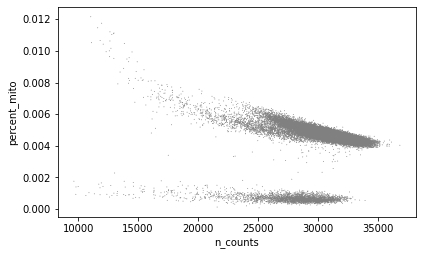

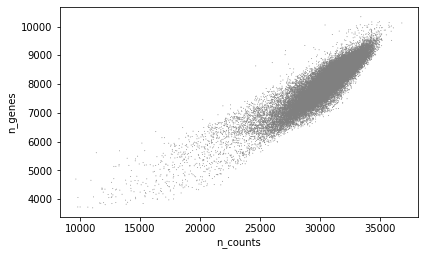

In [12]:
sc.pp.filter_cells(stem_adata, min_genes=200)
sc.pp.filter_genes(stem_adata, min_cells=3)

mito_genes = stem_adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
stem_adata.obs['percent_mito'] = np.sum(
    stem_adata[:, mito_genes].X, axis=1) / np.sum(stem_adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
stem_adata.obs['n_counts'] = stem_adata.X.sum(axis=1)

sc.pl.scatter(stem_adata, x='n_counts', y='percent_mito')
sc.pl.scatter(stem_adata, x='n_counts', y='n_genes')

Trying to set attribute `.obs` of view, copying.


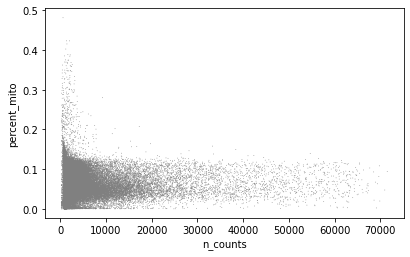

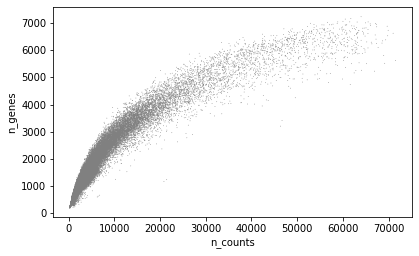

In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [14]:
adata = adata[adata.obs.percent_mito < 0.2, :]
adata

View of AnnData object with n_obs × n_vars = 47981 × 10520 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [15]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
adata.raw = adata
adata

/miniconda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


AnnData object with n_obs × n_vars = 47981 × 10520 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'
    uns: 'log1p'

In [16]:
np.min(adata.raw.X), np.max(adata.raw.X)

(0.0, 12.696036)

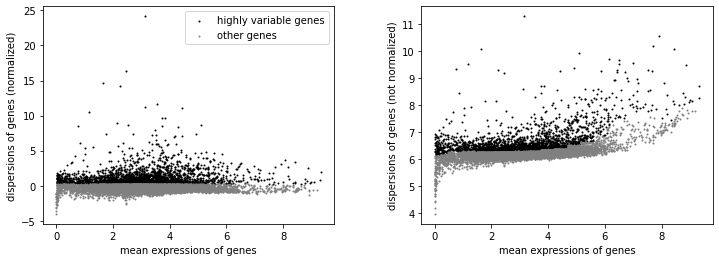

In [17]:
sc.pp.highly_variable_genes(adata, min_mean=0.0, max_mean=10., min_disp=0.25)
sc.pl.highly_variable_genes(adata)

In [18]:
np.count_nonzero(adata.var.highly_variable)

2560

In [19]:
# adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=None)
adata

AnnData object with n_obs × n_vars = 47981 × 10520 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [20]:
stem_adata.raw = stem_adata
sc.pp.scale(stem_adata, max_value=None)
stem_adata

AnnData object with n_obs × n_vars = 36044 × 10553 
    obs: 'assigned', 'cell_name', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'total_counts', 'total_counts_MT', 'pseudo', 'sample_id', 'well_id', 'well_type', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [21]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)

In [22]:
sc.tl.pca(stem_adata, svd_solver='arpack')
sc.pp.neighbors(stem_adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(stem_adata)

In [23]:
"""
SCA1: ATXN1
CD29: ITGB1
OCT4: POU5F1
"""
markers = ['CD24', 'ITGB1', 'EPCAM', 'CD44']
# more traditional stem markers
markers += ['SOX2', 'POU5F1', 'GATA6', 'NANOG']

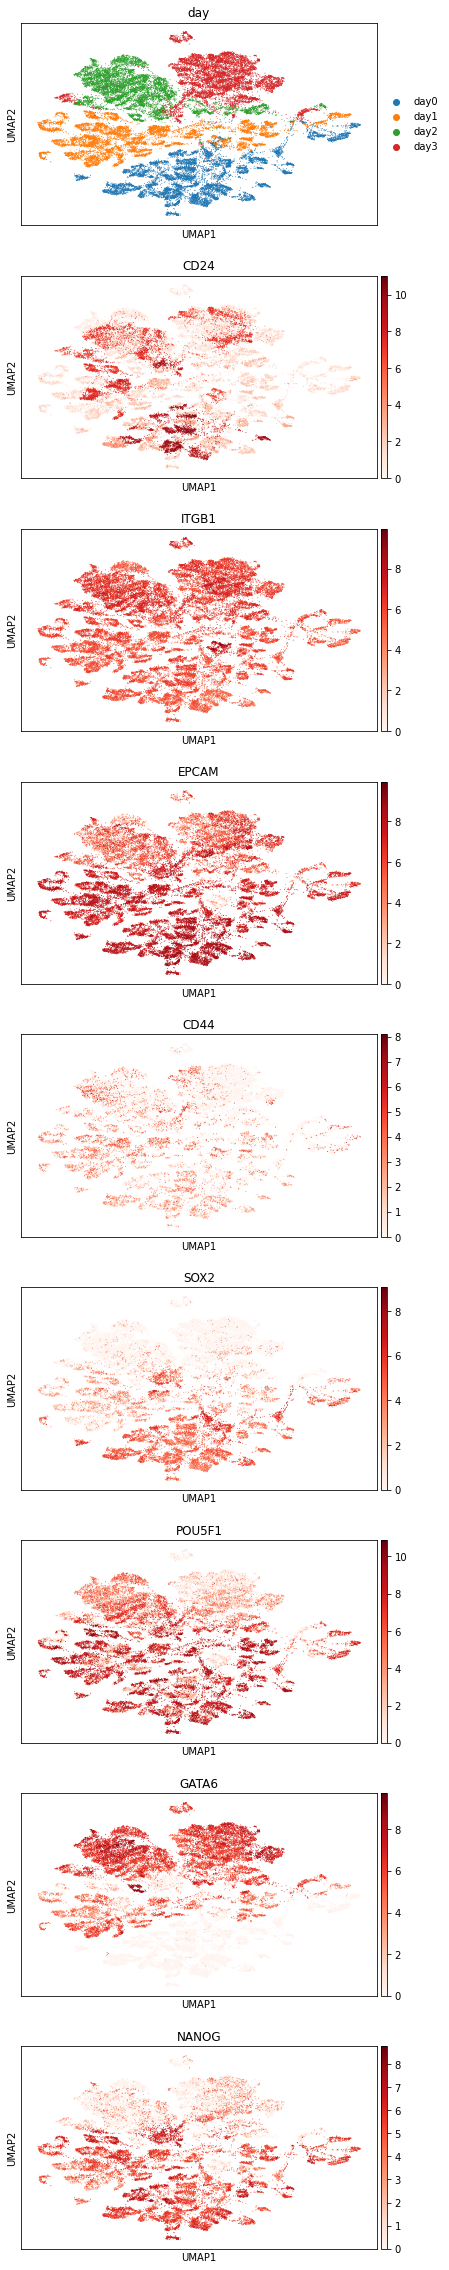

In [24]:
colors = ['day']
colors += markers
sc.pl.umap(stem_adata, color=colors, ncols=1, color_map='Reds')

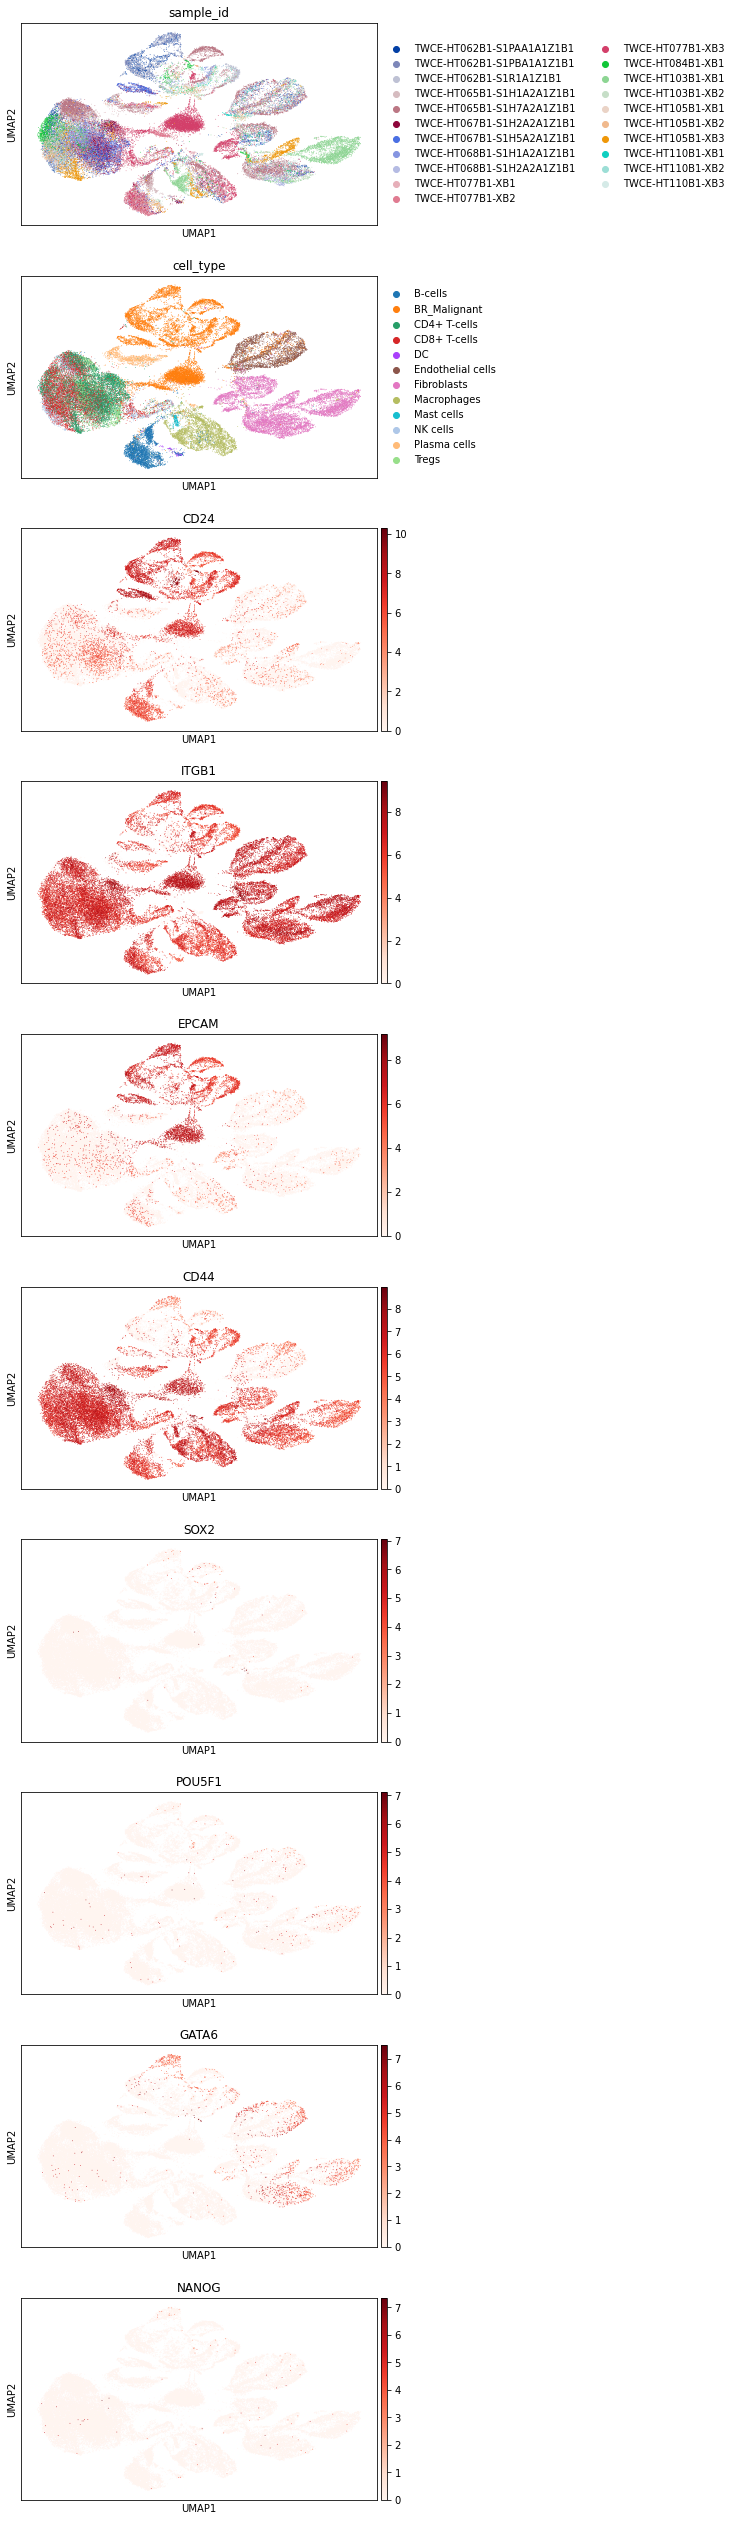

In [25]:
colors = ['sample_id', 'cell_type']
colors += markers
sc.pl.umap(adata, color=colors, ncols=1, color_map='Reds')

In [26]:
cell_type_key = 'cell_type'
tumor_adata = adata[adata.obs[cell_type_key]=='BR_Malignant'].copy()
tumor_adata

AnnData object with n_obs × n_vars = 10115 × 10520 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'sample_id_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

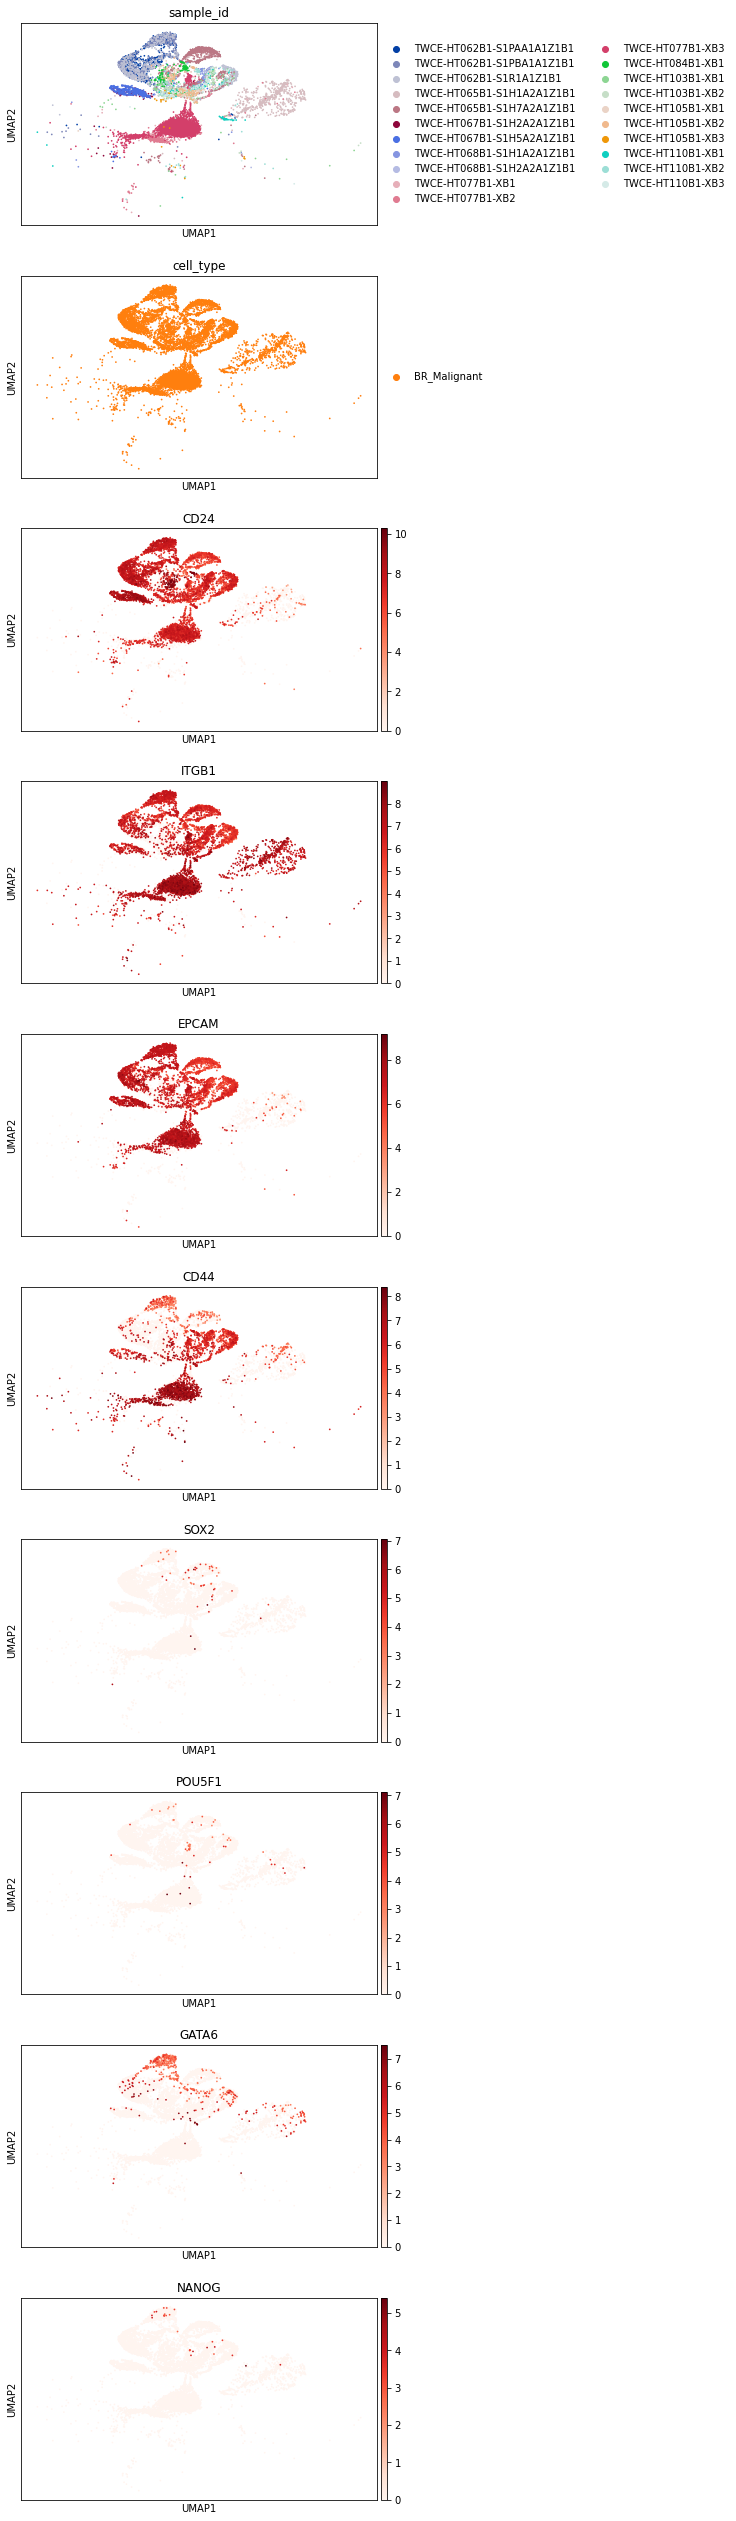

In [27]:
colors = ['sample_id', 'cell_type']
colors += markers
sc.pl.umap(tumor_adata, color=colors, ncols=1, color_map='Reds')

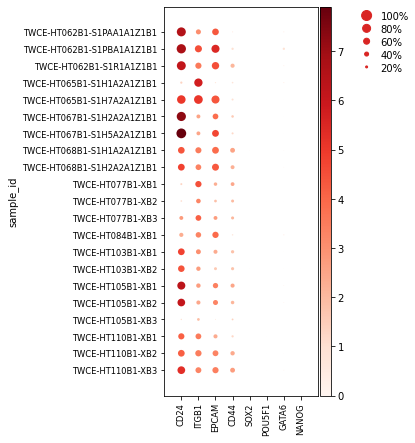

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[2.8, 0, 0.2, 0.5, 0.25])

In [28]:
sc.pl.dotplot(tumor_adata, markers, groupby='sample_id')

In [ ]:
# sample_id = 'TWCE-HT062B1-S1PAA1A1Z1B1'
sample_id = 'TWCE-HT065B1-S1H7A2A1Z1B1'
colors = ['sample_id', 'cell_type']
colors += markers
sc.pl.umap(tumor_adata[tumor_adata.obs['sample_id']==sample_id],
           color=colors, ncols=1, color_map='Reds')

In [ ]:
sorted(set(tumor_adata.obs['sample_id']))

In [ ]:
# tumor_adata = tumor_adata[tumor_adata.obs['sample_id']==sample_id].copy()
# tumor_adata

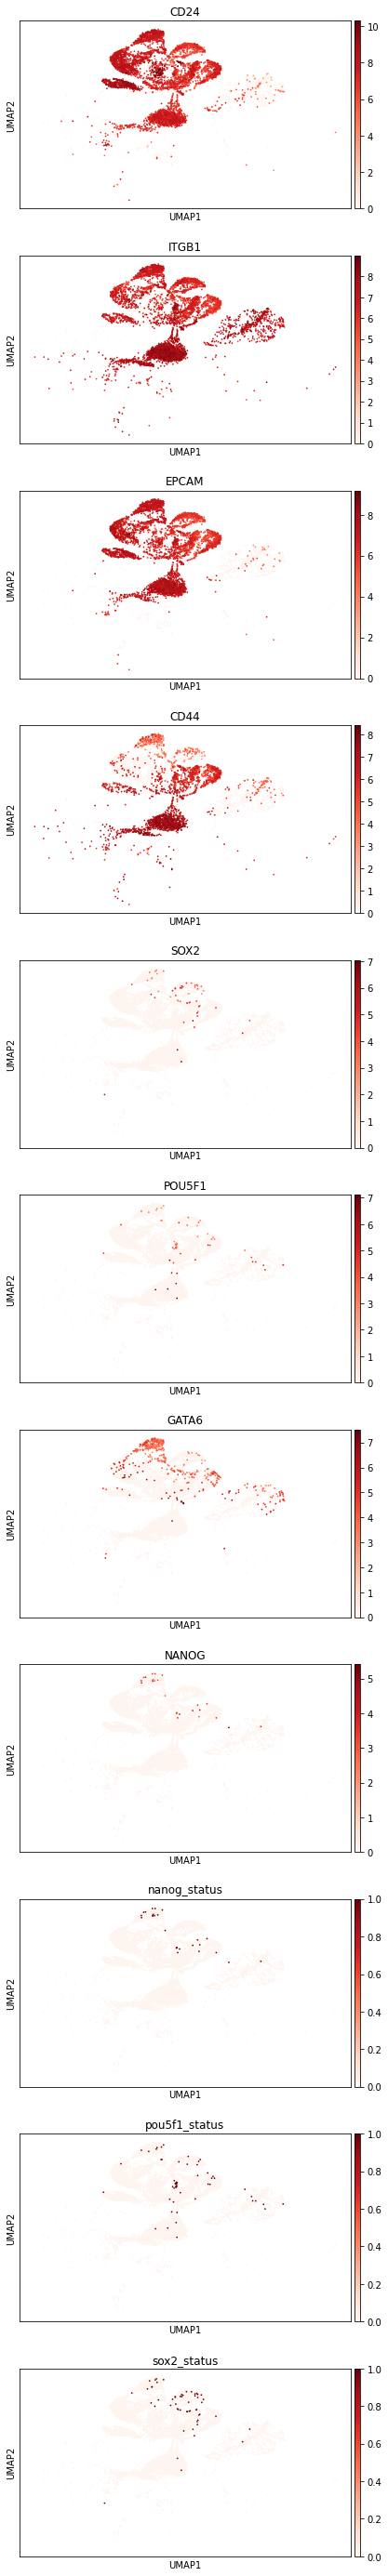

In [29]:
colors = [x for x in markers]
colors += ['nanog_status', 'pou5f1_status', 'sox2_status']
p_adata = tumor_adata.copy()
p_adata.obs['nanog_status'] = (tumor_adata.raw[:, tumor_adata.var.index=='NANOG'].X > .1).flatten()
p_adata.obs['pou5f1_status'] = (tumor_adata.raw[:, tumor_adata.var.index=='POU5F1'].X > .1).flatten()
p_adata.obs['sox2_status'] = (tumor_adata.raw[:, tumor_adata.var.index=='SOX2'].X > .1).flatten()


sc.pl.umap(p_adata,
           color=colors, ncols=1, color_map='Reds', use_raw=True)

In [30]:
tumor_adata.obs['nanog_status'] = p_adata.obs['nanog_status']
tumor_adata.obs['pou5f1_status'] = p_adata.obs['pou5f1_status']
tumor_adata.obs['sox2_status'] = p_adata.obs['sox2_status']

(Counter(tumor_adata.obs['nanog_status']), 
 Counter(tumor_adata.obs['pou5f1_status']), 
 Counter(tumor_adata.obs['sox2_status']))

(Counter({False: 10089, True: 26}),
 Counter({False: 10062, True: 53}),
 Counter({False: 10060, True: 55}))

In [31]:
import pollock
nanog_cells = pollock.balancedish_training_generator(tumor_adata, 'nanog_status', 25)[0].obs.index
pou5f1_cells = pollock.balancedish_training_generator(tumor_adata, 'pou5f1_status', 50)[0].obs.index
sox2_cells = pollock.balancedish_training_generator(tumor_adata, 'sox2_status', 50)[0].obs.index

nanog_cells, pou5f1_cells, sox2_cells

(Index(['HT062B1_S1PA_AATGAAGAGTAGAATC-1', 'HT062B1_S1PA_ACGGAAGAGAACTTCC-1',
        'HT062B1_S1PA_CACTGGGAGGGCTTCC-1', 'HT062B1_S1PA_CCACGAGAGAGCATAT-1',
        'HT062B1_S1PA_CTAACCCCAGGGAATC-1', 'HT062B1_S1PA_GAACTGTCAAACTAAG-1',
        'HT062B1_S1PA_GACTCAATCTCATTAC-1', 'HT062B1_S1PA_GGAATCTTCGCATTGA-1',
        'HT062B1_S1PA_GGGTTTAAGGATTTCC-1', 'HT062B1_S1PA_GGTGGCTAGGATTTCC-1',
        'HT062B1_S1PA_GTGCTGGCATTCTCCG-1', 'HT062B1_S1PA_TACGTCCCAAATGAGT-1',
        'HT062B1_S1PA_TATCGCCCACGGTGAA-1', 'HT062B1_S1PA_TCGCTTGGTAGTTCCA-1',
        'HT062B1_S1PA_TCGGTCTAGATAGTGT-1', 'HT062B1_S1PB_ATCGTGACAAGATTGA-1',
        'HT062B1_S1PB_CGGACACAGAGGTCAC-1', 'HT062B1_S1R1_AAGGTAAAGAGAGTGA-1',
        'HT062B1_S1R1_AGTGTTGCAGCCGGTT-1', 'HT062B1_S1R1_ATTCTACAGAGGCGTT-1',
        'HT062B1_S1R1_CGAGAAGCAATAACCC-1', 'HT062B1_S1R1_CTTCCGAGTATGCGTT-1',
        'HT062B1_S1R1_GTTGAACCAGAGCCCT-1', 'HT062B1_S1R1_TCCTTCTAGTTCCATG-1',
        'HT062B1_S1R1_TTCACGCTCATGCAGT-1', 'HT062B1_S1R1_TTTGATC

In [32]:
# tumor_adata[sox2_cells].obs['sox2_status']

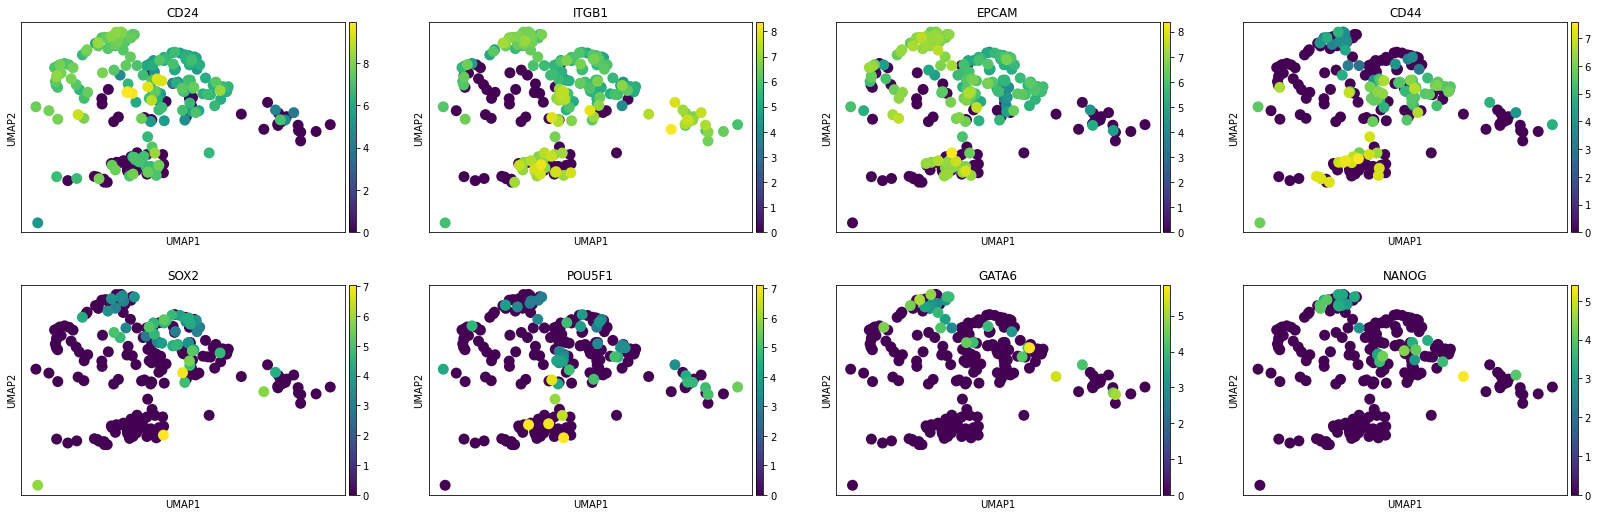

In [33]:
idxs = np.concatenate((nanog_cells, pou5f1_cells, sox2_cells))
sc.pl.umap(tumor_adata[idxs], color=markers)

In [34]:
n = 500

idxs = tumor_adata.obs.index.to_numpy()
np.random.shuffle(idxs)

remaining_idxs = idxs[:n]

train_idxs = np.concatenate((nanog_cells, pou5f1_cells, sox2_cells, remaining_idxs))
np.random.shuffle(idxs)

val_idxs = np.asarray([i for i in tumor_adata.obs.index if i not in set(train_idxs)])

tumor_train_adata = tumor_adata.copy()[train_idxs]
tumor_val_adata = tumor_adata.copy()[val_idxs]


tumor_train_adata, tumor_val_adata

(View of AnnData object with n_obs × n_vars = 750 × 10520 
     obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts', 'nanog_status', 'pou5f1_status', 'sox2_status'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'log1p', 'pca', 'neighbors', 'umap', 'sample_id_colors', 'cell_type_colors'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs',
 View of AnnData object with n_obs × n_vars = 9381 × 10520 
     obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts', 'nanog_status', 'pou5f1_status', 'sox2_status'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'log1p', 'pca', 'neighbors', 'umap', 'sample_id_colors', 'cell_type_colors'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs')

In [35]:
# stem_train_adata, stem_val_adata = pollock.balancedish_training_generator(stem_adata, 'day', 50)

# stem_train_adata, stem_val_adata

In [36]:
# stem_train_adata.obs['dataset'], stem_val_adata.obs['dataset'] = 'stem', 'stem'
tumor_train_adata.obs['dataset'], tumor_val_adata.obs['dataset'] = 'tumor', 'tumor'

combined_train_adata = tumor_train_adata.copy()
combined_val_adata = tumor_val_adata.copy()
combined_train_adata, combined_val_adata

Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


(AnnData object with n_obs × n_vars = 750 × 10520 
     obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts', 'nanog_status', 'pou5f1_status', 'sox2_status', 'dataset'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'log1p', 'pca', 'neighbors', 'umap', 'sample_id_colors', 'cell_type_colors'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs',
 AnnData object with n_obs × n_vars = 9381 × 10520 
     obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts', 'nanog_status', 'pou5f1_status', 'sox2_status', 'dataset'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'log1p', 'pca', 'neighbors', 'umap', 'sample_id_colors', 'cell_type_colors'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs')

In [37]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

X_train = np.copy(combined_train_adata.X)
X_train_tumor = np.copy(combined_train_adata[combined_train_adata.obs['dataset']=='tumor'].X)
# X_train_stem = np.copy(combined_train_adata[combined_train_adata.obs['dataset']=='stem'].X)
X_val = np.copy(combined_val_adata.X)
X_val_tumor = np.copy(combined_val_adata[combined_val_adata.obs['dataset']=='tumor'].X)
# X_val_stem = np.copy(combined_val_adata[combined_val_adata.obs['dataset']=='stem'].X)

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_train_tumor = scaler.transform(X_train_tumor)
# X_train_stem = scaler.transform(X_train_stem)
X_val_tumor = scaler.transform(X_val_tumor)
# X_val_stem = scaler.transform(X_val_stem)

X_train.shape, X_val.shape

((750, 10520), (9381, 10520))

In [38]:
TRAIN_BUF = 10000
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices(X_val).batch(BATCH_SIZE)
train_dataset_tumor = tf.data.Dataset.from_tensor_slices(X_train_tumor).batch(BATCH_SIZE)
# train_dataset_stem = tf.data.Dataset.from_tensor_slices(X_train_stem).batch(BATCH_SIZE)
val_dataset_tumor = tf.data.Dataset.from_tensor_slices(X_val_tumor[:1000]).batch(BATCH_SIZE)
# val_dataset_stem = tf.data.Dataset.from_tensor_slices(X_val_stem[:1000]).batch(BATCH_SIZE)

In [39]:
class BVAE(tf.keras.Model):
  def __init__(self, latent_dim, input_size):
    super(BVAE, self).__init__()
    self.latent_dim = latent_dim
    self.input_size = input_size
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(input_size,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(input_size),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [40]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x, alpha=0.00005, boost_idxs=None, boost_value=2.):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  kl_loss = .5 * tf.reduce_sum(tf.exp(logvar) + tf.square(mean) - 1. - logvar, axis=1)
    
  if boost_idxs is not None:
#     diff = (x - x_logit) + (boost_value * (tf.gather(x, boost_idxs) - tf.gather(x_logit, boost_idxs)))
    normal_reconstruction =  tf.reduce_sum(tf.square((x - x_logit)), axis=1)
    boost_reconstruction = boost_value * tf.reduce_sum(tf.square(((tf.gather(x, boost_idxs, axis=1) - tf.gather(x_logit, boost_idxs, axis=1)))), axis=1)
    reconstruction_loss = .5 * (normal_reconstruction + boost_reconstruction)
#     diff = tf.square((x - x_logit)) + tf.square((boost_value * (tf.gather(x, boost_idxs, axis=1) - tf.gather(x_logit, boost_idxs, axis=1))))
#     reconstruction_loss = .5 * tf.reduce_sum(tf.square(diff), axis=1)
  else:
    reconstruction_loss = .5 * tf.reduce_sum(tf.square((x - x_logit)), axis=1)

  overall_loss = tf.reduce_mean(reconstruction_loss + alpha * kl_loss)
  return overall_loss

@tf.function
def compute_apply_gradients(model, x, optimizer, alpha=.00005, boost_idxs=None, boost_value=None):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, alpha=alpha, boost_idxs=boost_idxs, boost_value=boost_value)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    

In [41]:
epochs = 100
latent_dim = 100
# alpha = 0.1
alpha = .1

## locate idxs to boost
to_boost = ['SOX2', 'NANOG', 'POU5F1']
boost_idxs = np.asarray([i for i, gene in enumerate(combined_train_adata.var.index)
                            if gene in to_boost])
boost_value = 1000.

model = BVAE(latent_dim, X_train.shape[1])

In [43]:
# generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer, alpha=alpha, boost_idxs=boost_idxs,
                           boost_value=boost_value)
  end_time = time.time()

  if epoch % 1 == 0:
    train_tumor_loss = tf.keras.metrics.Mean()
    for x in train_dataset_tumor:
        train_tumor_loss(compute_loss(model, x, alpha=alpha, boost_idxs=boost_idxs, boost_value=boost_value))
        
    non_boost_train_tumor_loss = tf.keras.metrics.Mean()
    for x in train_dataset_tumor:
        non_boost_train_tumor_loss(compute_loss(model, x, alpha=alpha,
                                                boost_idxs=None, boost_value=None))
        
#     train_stem_loss = tf.keras.metrics.Mean()
#     for x in train_dataset_stem:
#         train_stem_loss(compute_loss(model, x, alpha=alpha, boost_idxs=boost_idxs, boost_value=boost_value))
        
    val_tumor_loss = tf.keras.metrics.Mean()
    for x in val_dataset_tumor:
        val_tumor_loss(compute_loss(model, x, alpha=alpha, boost_idxs=boost_idxs, boost_value=boost_value))
        
#     val_stem_loss = tf.keras.metrics.Mean()
#     for x in val_dataset_stem:
#         val_stem_loss(compute_loss(model, x, alpha=alpha, boost_idxs=boost_idxs, boost_value=boost_value))
#     loss = tf.keras.metrics.Mean()
#     for test_x in test_dataset:
#       loss(compute_loss(model, test_x, alpha=alpha))
#       break

#     print(f'epoch: {epoch}, val loss: {compute_loss(model, next(iter(test_dataset)), alpha)}')
    print(f'epoch: {epoch}, nonboost train tumor loss: {non_boost_train_tumor_loss.result()}, \
train tumor loss: {train_tumor_loss.result()}, \
train stem loss: ., val tumor loss: {val_tumor_loss.result()}, \
val stem loss: .')

epoch: 1, nonboost train tumor loss: 267.12640380859375, train tumor loss: 273.7571716308594, train stem loss: ., val tumor loss: 1752.6527099609375, val stem loss: .
epoch: 2, nonboost train tumor loss: 252.49256896972656, train tumor loss: 257.7713317871094, train stem loss: ., val tumor loss: 1742.186279296875, val stem loss: .
epoch: 3, nonboost train tumor loss: 246.02691650390625, train tumor loss: 251.3565216064453, train stem loss: ., val tumor loss: 1734.10009765625, val stem loss: .
epoch: 4, nonboost train tumor loss: 242.87744140625, train tumor loss: 247.50732421875, train stem loss: ., val tumor loss: 1735.8421630859375, val stem loss: .
epoch: 5, nonboost train tumor loss: 239.74749755859375, train tumor loss: 244.38011169433594, train stem loss: ., val tumor loss: 1726.1051025390625, val stem loss: .
epoch: 6, nonboost train tumor loss: 236.14979553222656, train tumor loss: 239.762451171875, train stem loss: ., val tumor loss: 1725.52001953125, val stem loss: .
epoch: 7

epoch: 51, nonboost train tumor loss: 200.7696990966797, train tumor loss: 201.2519073486328, train stem loss: ., val tumor loss: 1687.3251953125, val stem loss: .
epoch: 52, nonboost train tumor loss: 200.5513916015625, train tumor loss: 200.9452362060547, train stem loss: ., val tumor loss: 1690.2252197265625, val stem loss: .
epoch: 53, nonboost train tumor loss: 199.92530822753906, train tumor loss: 200.36749267578125, train stem loss: ., val tumor loss: 1687.8045654296875, val stem loss: .
epoch: 54, nonboost train tumor loss: 199.39891052246094, train tumor loss: 199.76661682128906, train stem loss: ., val tumor loss: 1687.86572265625, val stem loss: .
epoch: 55, nonboost train tumor loss: 198.81982421875, train tumor loss: 199.22206115722656, train stem loss: ., val tumor loss: 1687.4931640625, val stem loss: .
epoch: 56, nonboost train tumor loss: 198.28233337402344, train tumor loss: 198.82081604003906, train stem loss: ., val tumor loss: 1689.5096435546875, val stem loss: .
e

In [44]:
combined_adata = combined_train_adata.concatenate(combined_val_adata)
mean, logvar = model.encode(combined_adata.X)
cell_embeddings = model.reparameterize(mean, logvar).numpy()
cell_embeddings.shape

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.
Or pass `index_unique!=None` to `.concatenate`.


(10131, 100)

#### cell embeddings

In [45]:
import umap

combined_adata.obsm['cell_embeddings'] = cell_embeddings
combined_adata.obsm['cell_embedding_umap'] = umap.UMAP().fit_transform(combined_adata.obsm['cell_embeddings'])
combined_adata.obs['cell_embedding_umap1'] = combined_adata.obsm['cell_embedding_umap'][:, 0]
combined_adata.obs['cell_embedding_umap2'] = combined_adata.obsm['cell_embedding_umap'][:, 1]

combined_adata

AnnData object with n_obs × n_vars = 10131 × 10520 
    obs: 'batch', 'cancer_type', 'cell_type', 'dataset', 'facs', 'method', 'n_counts', 'n_genes', 'nanog_status', 'organ_type', 'percent_mito', 'pou5f1_status', 'sample_id', 'sox2_status', 'species', 'tissue_type', 'cell_embedding_umap1', 'cell_embedding_umap2'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_pca', 'X_umap', 'cell_embeddings', 'cell_embedding_umap'

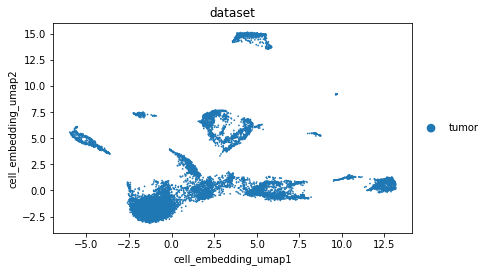

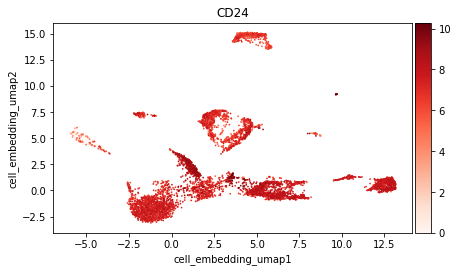

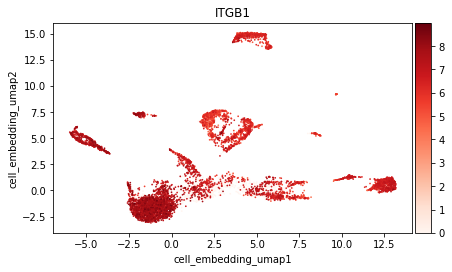

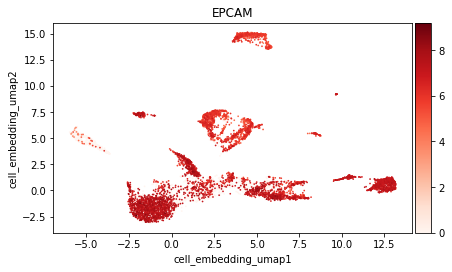

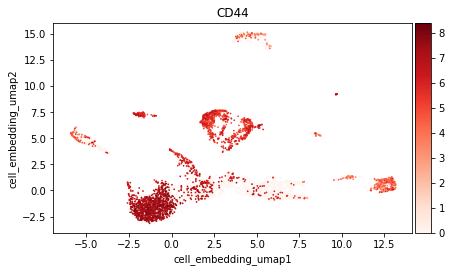

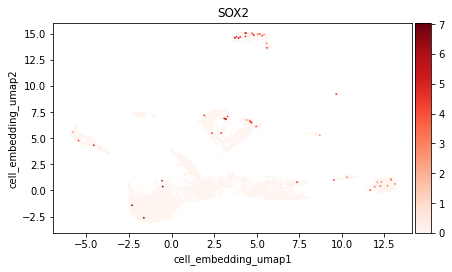

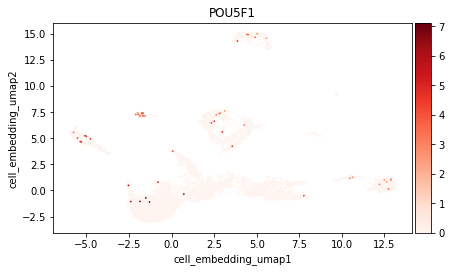

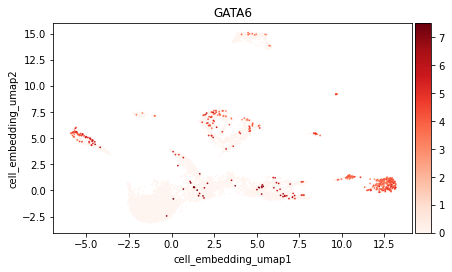

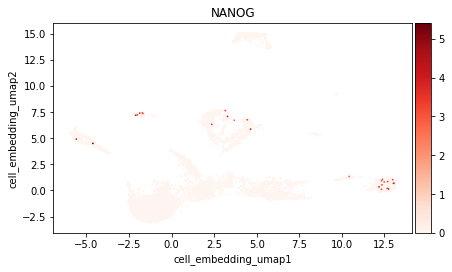

In [47]:
variables = ['dataset']
variables += markers
for var in variables:
#     if var in combined_adata.var.index or var in combined_adata.obs.columns:
    sc.pl.scatter(combined_adata, x='cell_embedding_umap1', y='cell_embedding_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()

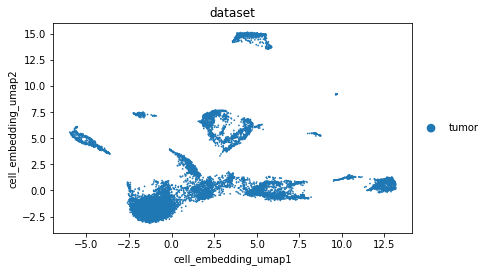

Trying to set attribute `.uns` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


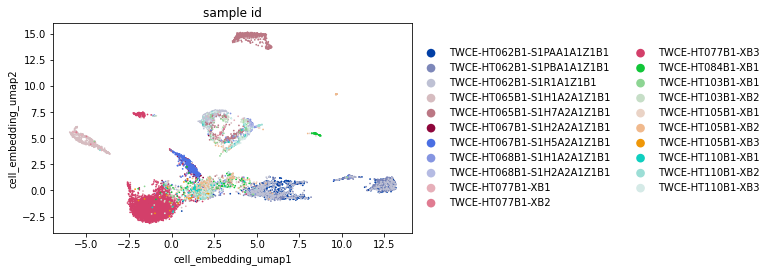

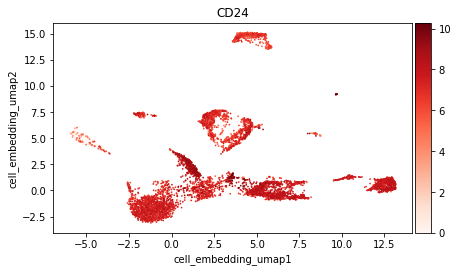

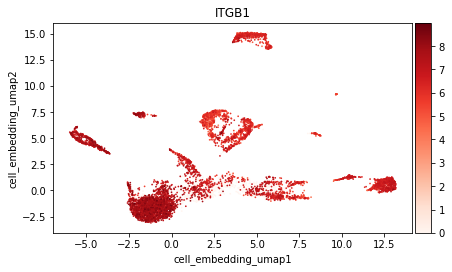

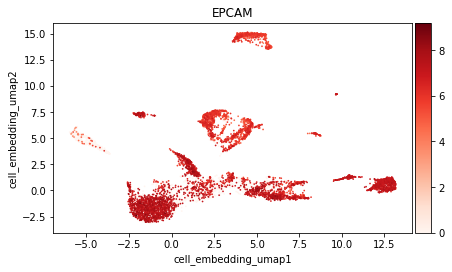

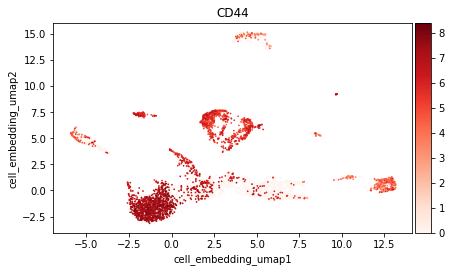

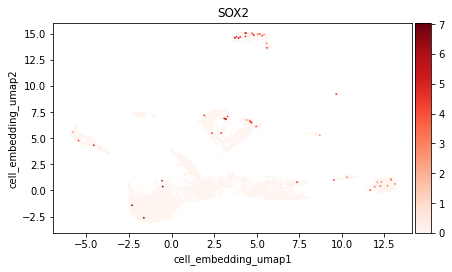

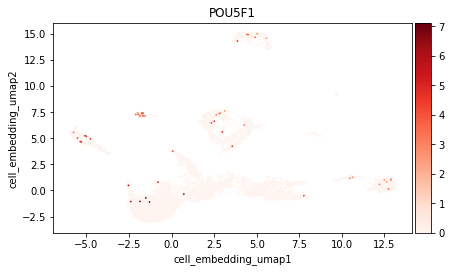

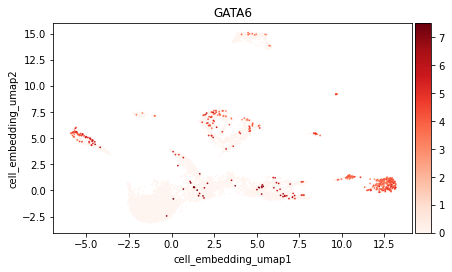

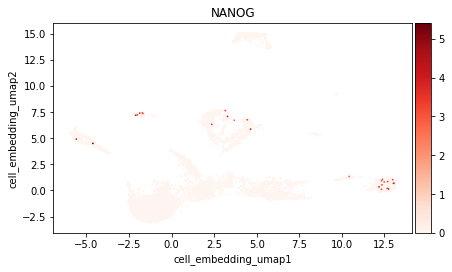

In [48]:
variables = ['dataset', 'sample_id']
variables += markers
for var in variables:
#     if var in combined_adata.var.index or var in combined_adata.obs.columns:
    sc.pl.scatter(combined_adata[combined_adata.obs['dataset']=='tumor'],
                  x='cell_embedding_umap1', y='cell_embedding_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()

#### sample batch correction

In [49]:
sample_id_to_avg = {sample_id:np.mean(
                    combined_adata[combined_adata.obs['sample_id']==sample_id].obsm['cell_embeddings'],
                    axis=0)
                    for sample_id in sorted(set(tumor_adata.obs['sample_id']))}

overall_mean = np.mean(np.asarray(list(sample_id_to_avg.values())), axis=0)
sample_id_to_delta = {sample_id:overall_mean - avg
                     for sample_id, avg in sample_id_to_avg.items()}

In [50]:
def batch_correction_operation(latent, sample_id):
    return latent + sample_id_to_delta[sample_id]
#     if dataset == 'stem': return latent + stem_delta
#     if dataset == 'tumor': return latent + tumor_delta


corrected_embeddings = np.asarray([batch_correction_operation(latent, sid) if dataset=='tumor' else latent
                           for latent, dataset, sid in zip(combined_adata.obsm['cell_embeddings'],
                                                      combined_adata.obs['dataset'],
                                                      combined_adata.obs['sample_id'])])

combined_adata.obsm['corrected_embeddings'] = corrected_embeddings
combined_adata.obsm['corrected_embeddings_umap'] = umap.UMAP(
    ).fit_transform(combined_adata.obsm['corrected_embeddings'])
combined_adata.obs['corrected_embeddings_umap1'] = combined_adata.obsm['corrected_embeddings_umap'][:, 0]
combined_adata.obs['corrected_embeddings_umap2'] = combined_adata.obsm['corrected_embeddings_umap'][:, 1]

combined_adata

AnnData object with n_obs × n_vars = 10131 × 10520 
    obs: 'batch', 'cancer_type', 'cell_type', 'dataset', 'facs', 'method', 'n_counts', 'n_genes', 'nanog_status', 'organ_type', 'percent_mito', 'pou5f1_status', 'sample_id', 'sox2_status', 'species', 'tissue_type', 'cell_embedding_umap1', 'cell_embedding_umap2', 'corrected_embeddings_umap1', 'corrected_embeddings_umap2'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_colors'
    obsm: 'X_pca', 'X_umap', 'cell_embeddings', 'cell_embedding_umap', 'corrected_embeddings', 'corrected_embeddings_umap'

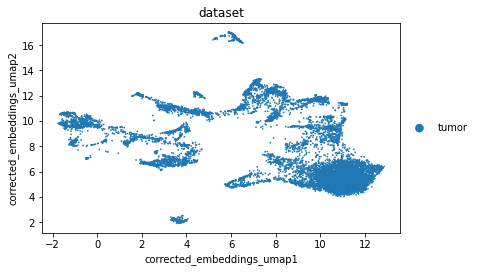

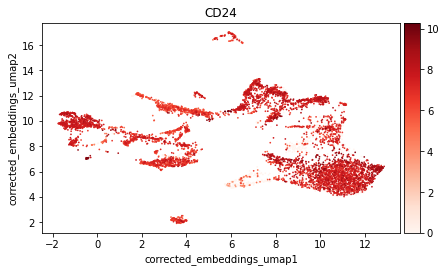

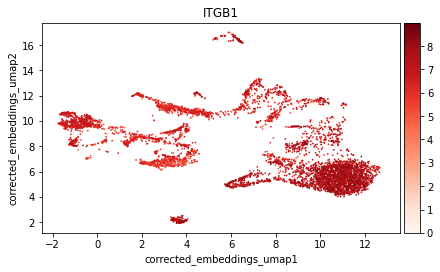

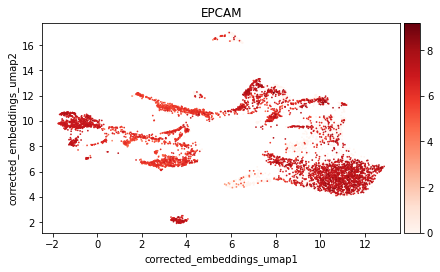

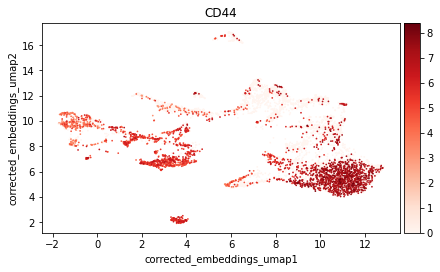

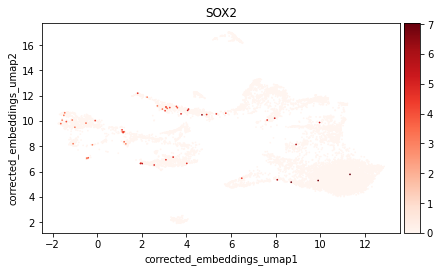

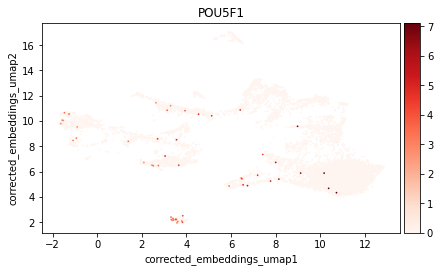

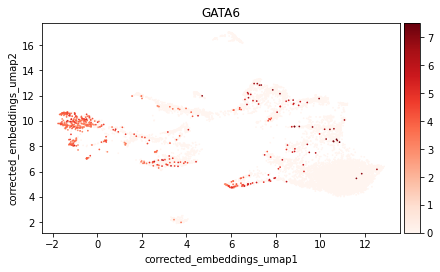

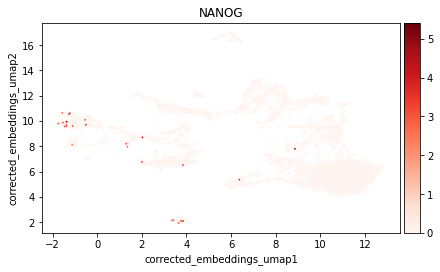

In [51]:
variables = ['dataset']
variables += markers
for var in variables:
#     if var in combined_adata.var.index or var in combined_adata.obs.columns:
    sc.pl.scatter(combined_adata, x='corrected_embeddings_umap1', y='corrected_embeddings_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()

In [52]:
# combined_adata.uns.pop('sample_id_colors')

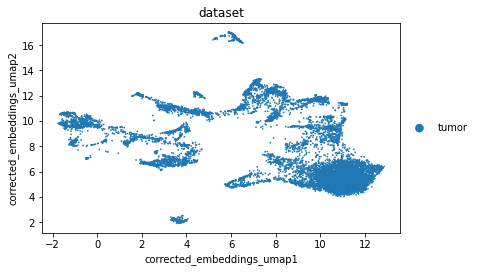

Trying to set attribute `.uns` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


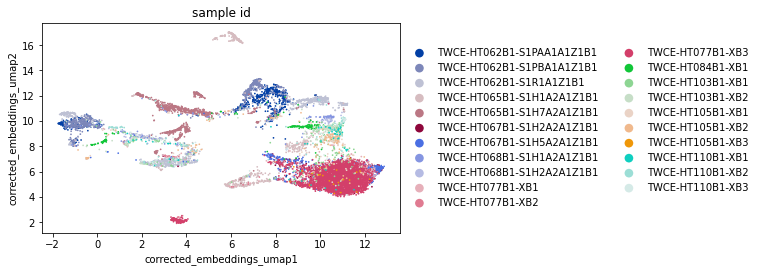

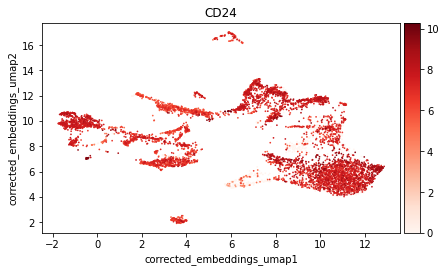

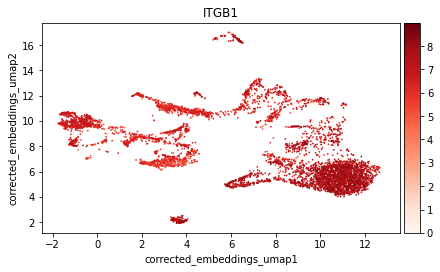

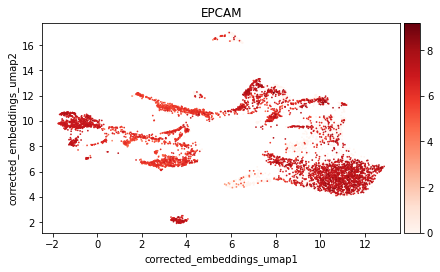

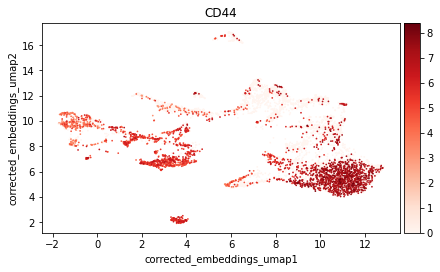

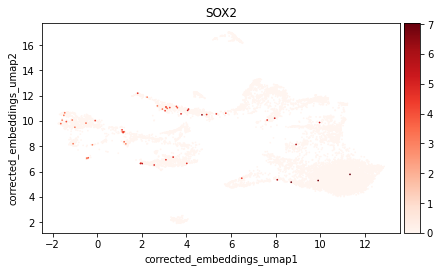

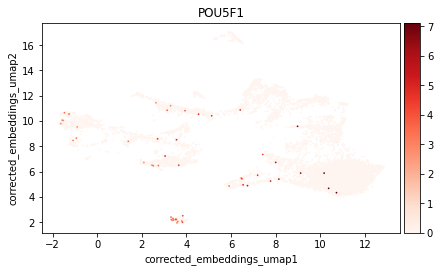

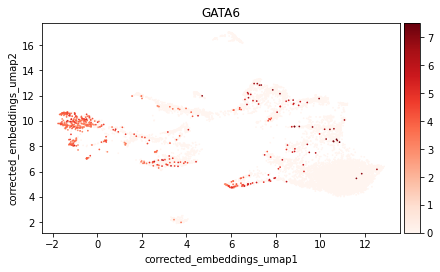

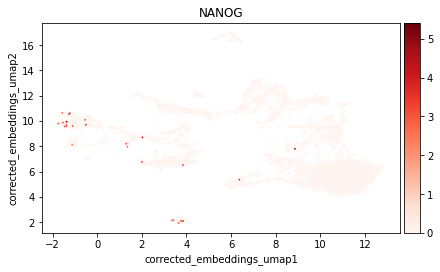

In [53]:
variables = ['dataset', 'sample_id']
variables += markers
for var in variables:
#     if var in combined_adata.var.index or var in combined_adata.obs.columns:
    sc.pl.scatter(combined_adata[combined_adata.obs['dataset']=='tumor'],
                  x='corrected_embeddings_umap1', y='corrected_embeddings_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()

In [ ]:
# from sklearn.decomposition import PCA
# combined_adata.obsm['cell_embedding_pca'] = PCA().fit_transform(combined_adata.obsm['cell_embeddings'])
# combined_adata.obsm['cell_embedding_pca'][combined_adata.obsm['cell_embedding_pca'] > 50] = 50
# combined_adata.obsm['cell_embedding_pca'][combined_adata.obsm['cell_embedding_pca'] < -50] = -50
# combined_adata.obs['cell_embedding_pca1'] = combined_adata.obsm['cell_embedding_pca'][:, 0]
# combined_adata.obs['cell_embedding_pca2'] = combined_adata.obsm['cell_embedding_pca'][:, 3]

# combined_adata

In [ ]:
# variables = ['dataset', 'day']
# variables += markers
# for var in variables:
# #     if var in combined_adata.var.index or var in combined_adata.obs.columns:
#     sc.pl.scatter(combined_adata, x='cell_embedding_pca1', y='cell_embedding_pca2', color=var,
#                  frameon=False, color_map='Reds', )

#     plt.show()

#### batch corrected and transformed

In [ ]:
# avg_tumor = np.mean(combined_adata[combined_adata.obs['dataset']=='tumor'].obsm['cell_embeddings'], axis=0)
avg_tumor = np.mean(combined_adata[combined_adata.obs['dataset']=='tumor'].obsm['corrected_embeddings'], axis=0)
# avg_stem = np.mean(combined_adata[combined_adata.obs['dataset']=='stem'].obsm['cell_embeddings'], axis=0)
avg_stem = np.mean(combined_adata[combined_adata.obs['dataset']=='stem'].obsm['corrected_embeddings'], axis=0)

mean = np.mean(np.asarray([avg_stem, avg_tumor]), axis=0)

stem_delta = mean - avg_stem
tumor_delta = mean - avg_tumor

delta = avg_stem - avg_tumor

In [ ]:
def operation(latent, dataset):
    if dataset == 'stem': return latent + stem_delta
    if dataset == 'tumor': return latent + tumor_delta
#     if dataset == 'normal': return latent + normal_delta
    
#     if dataset == 'tumor': return latent + delta
#     return latent

transformed_embeddings = np.asarray([operation(latent, dataset)
#                            for latent, dataset in zip(combined_adata.obsm['cell_embeddings'],
                            for latent, dataset in zip(combined_adata.obsm['corrected_embeddings'],
                                                      combined_adata.obs['dataset'])])

combined_adata.obsm['transformed_embeddings'] = transformed_embeddings
combined_adata.obsm['transformed_embeddings_umap'] = umap.UMAP(
    ).fit_transform(combined_adata.obsm['transformed_embeddings'])
combined_adata.obs['transformed_embeddings_umap1'] = combined_adata.obsm['transformed_embeddings_umap'][:, 0]
combined_adata.obs['transformed_embeddings_umap2'] = combined_adata.obsm['transformed_embeddings_umap'][:, 1]

combined_adata

In [ ]:
variables = ['dataset', 'day']
variables += markers
for var in variables:
#     if var in combined_adata.var.index or var in combined_adata.obs.columns:
    sc.pl.scatter(combined_adata, x='transformed_embeddings_umap1', y='transformed_embeddings_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()

In [ ]:
variables = ['dataset', 'sample_id']
variables += markers
for var in variables:
#     if var in combined_adata.var.index or var in combined_adata.obs.columns:
    sc.pl.scatter(combined_adata[combined_adata.obs['dataset']=='tumor'],
                  x='transformed_embeddings_umap1', y='transformed_embeddings_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()

In [ ]:
variables = ['dataset', 'sample_id']
variables += markers
for var in variables:
#     if var in combined_adata.var.index or var in combined_adata.obs.columns:
    sc.pl.scatter(combined_adata[combined_adata.obs['sample_id']=='TWCE-HT062B1-S1PBA1A1Z1B1'],
                  x='transformed_embeddings_umap1', y='transformed_embeddings_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()

In [ ]:
variables = ['dataset', 'sample_id']
variables += markers
for var in variables:
#     if var in combined_adata.var.index or var in combined_adata.obs.columns:
    sc.pl.scatter(combined_adata[combined_adata.obs['sample_id']=='TWCE-HT065B1-S1H7A2A1Z1B1'],
                  x='transformed_embeddings_umap1', y='transformed_embeddings_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()
# TWCE-HT065B1-S1H7A2A1Z1B1

In [ ]:
variables = ['dataset', 'sample_id']
variables += markers
for var in variables:
#     if var in combined_adata.var.index or var in combined_adata.obs.columns:
    sc.pl.scatter(combined_adata[combined_adata.obs['sample_id']=='TWCE-HT077B1-XB3'],
                  x='transformed_embeddings_umap1', y='transformed_embeddings_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()


In [ ]:
variables = ['dataset', 'sample_id']
variables += markers
for var in variables:
#     if var in combined_adata.var.index or var in combined_adata.obs.columns:
    sc.pl.scatter(combined_adata[combined_adata.obs['sample_id']=='TWCE-HT110B1-XB1'],
                  x='transformed_embeddings_umap1', y='transformed_embeddings_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()


In [ ]:
sorted(set(tumor_train_adata.obs['sample_id']))

#### transformed and not batch corrected

In [ ]:
avg_tumor = np.mean(combined_adata[combined_adata.obs['dataset']=='tumor'].obsm['cell_embeddings'], axis=0)
# avg_tumor = np.mean(combined_adata[combined_adata.obs['dataset']=='tumor'].obsm['corrected_embeddings'], axis=0)
avg_stem = np.mean(combined_adata[combined_adata.obs['dataset']=='stem'].obsm['cell_embeddings'], axis=0)
# avg_stem = np.mean(combined_adata[combined_adata.obs['dataset']=='stem'].obsm['corrected_embeddings'], axis=0)

mean = np.mean(np.asarray([avg_stem, avg_tumor]), axis=0)

stem_delta = mean - avg_stem
tumor_delta = mean - avg_tumor

delta = avg_stem - avg_tumor

In [ ]:
def operation(latent, dataset):
    if dataset == 'stem': return latent + stem_delta
    if dataset == 'tumor': return latent + tumor_delta
#     if dataset == 'normal': return latent + normal_delta
    
#     if dataset == 'tumor': return latent + delta
#     return latent

transformed_embeddings = np.asarray([operation(latent, dataset)
                           for latent, dataset in zip(combined_adata.obsm['cell_embeddings'],
#                             for latent, dataset in zip(combined_adata.obsm['corrected_embeddings'],
                                                      combined_adata.obs['dataset'])])

combined_adata.obsm['unbatch_transformed_embeddings'] = transformed_embeddings
combined_adata.obsm['unbatch_transformed_embeddings_umap'] = umap.UMAP(
    ).fit_transform(combined_adata.obsm['unbatch_transformed_embeddings'])
combined_adata.obs['unbatch_transformed_embeddings_umap1'] = combined_adata.obsm['unbatch_transformed_embeddings_umap'][:, 0]
combined_adata.obs['unbatch_transformed_embeddings_umap2'] = combined_adata.obsm['unbatch_transformed_embeddings_umap'][:, 1]

combined_adata

In [ ]:
variables = ['dataset', 'day']
variables += markers
for var in variables:
#     if var in combined_adata.var.index or var in combined_adata.obs.columns:
    sc.pl.scatter(combined_adata, x='unbatch_transformed_embeddings_umap1',
                  y='unbatch_transformed_embeddings_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()

In [ ]:
variables = ['dataset', 'sample_id']
variables += markers
for var in variables:
#     if var in combined_adata.var.index or var in combined_adata.obs.columns:
    sc.pl.scatter(combined_adata[combined_adata.obs['dataset']=='tumor'],
                  x='unbatch_transformed_embeddings_umap1',
                  y='unbatch_transformed_embeddings_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()

In [ ]:
variables = ['dataset', 'sample_id']
variables += markers
for var in variables:
#     if var in combined_adata.var.index or var in combined_adata.obs.columns:
    sc.pl.scatter(combined_adata[combined_adata.obs['sample_id']=='TWCE-HT062B1-S1PBA1A1Z1B1'],
                  x='transformed_embeddings_umap1', y='transformed_embeddings_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()

In [ ]:
variables = ['dataset', 'sample_id']
variables += markers
for var in variables:
#     if var in combined_adata.var.index or var in combined_adata.obs.columns:
    sc.pl.scatter(combined_adata[combined_adata.obs['sample_id']=='TWCE-HT065B1-S1H7A2A1Z1B1'],
                  x='transformed_embeddings_umap1', y='transformed_embeddings_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()
# TWCE-HT065B1-S1H7A2A1Z1B1

Less than 100 mammary CSC cells with a phenotype of CD44+, CD24−/low, Lin− were able to generate palpable tumors in NOD/SCID mice, whereas CD44−, CD24+ breast cancer cells, even when injected at 100-fold higher cell densities, were unable to induce tumor formation [50, 56]. Similar results were obtained with breast CSCs expressing CD133+. There was no overlap in CD markers between the CD133+ and the CD44+, CD24− CSCs, but both populations displayed markedly enhanced self-renewal capacity and shared the expression of stemness genes (OCT4, NOTCH1, ALDH1, FGFR1, SOX1)

In [ ]:
br_stem_markers = ['CD24', 'ITGB1', 'EPCAM', 'CD44', 'PROM1', 'NCAM1', 'SOX2']

In [ ]:
# br_stem_markers = ['CD44', 'CD24', 'LIN28A', 'PROM1', 'POU5F1', 'NOTCH1', 'ALDH1A1', 'FGFR1', 'SOX1']
br_stem_markers = ['CD44', 'CD24', 'LIN28A', 'POU5F1', 'NOTCH1']

In [ ]:
for gene in br_stem_markers:
    tups = []
    for i in range(tumor_adata.obsm['X_pca'].shape[1]):
        position_vals = tumor_adata.obsm['X_pca'][:, i].flatten()
        gene_vals = tumor_adata[:, gene].X.flatten()

#         xs, ys = zip(*[(p, g) for p, g, t in zip(position_vals, gene_vals, tumor_adata.obs['dataset'])
#                                                 if t == 'stem'])
        correlation = scipy.stats.pearsonr(position_vals, gene_vals)
        r = correlation[0]
        tups.append((i, r, abs(r)))

        tumor_adata.obs[f'pca_{i}'] = position_vals
    tups = sorted(tups, key=lambda x: x[2], reverse=True)
    print(gene)
    print(tups[:5])


In [ ]:
for gene in br_stem_markers:
    tups = []
    for i in range(tumor_adata.obsm['cell_embeddings'].shape[1]):
        position_vals = tumor_adata.obsm['cell_embeddings'][:, i].flatten()
        gene_vals = tumor_adata[:, gene].X.flatten()

#         xs, ys = zip(*[(p, g) for p, g, t in zip(position_vals, gene_vals, tumor_adata.obs['dataset'])
#                                                 if t == 'stem'])
        correlation = scipy.stats.pearsonr(position_vals, gene_vals)
        r = correlation[0]
        tups.append((i, r, abs(r)))

        tumor_adata.obs[f'position_{i}'] = position_vals
    tups = sorted(tups, key=lambda x: x[2], reverse=True)
    print(gene)
    print(tups[:5])


In [ ]:
variables = ['sample_id', 'position_57']
variables += br_stem_markers
for var in variables:
    sc.pl.scatter(tumor_adata, x='cell_embedding_umap1', y='cell_embedding_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()

In [ ]:
sc.pl.umap(tumor_adata, color=variables, frameon=False, ncols=1, color_map='Reds')

# integration with single cell stem dataset

In [ ]:
expression_fp = '/data/stemness/ERP016000/counts.tsv'
metadata_fp = '/data/stemness/ERP016000/cell_metadata_cols.tsv'

In [ ]:
expression_df = pd.read_hdf(expression_fp.replace('.tsv', '.hd5'), 'df')
expression_df.index = [c.split('_')[-1] for c in expression_df.index]
expression_df = expression_df.transpose()
expression_df

In [ ]:
metadata_df = pd.read_csv(metadata_fp, sep='\t')
metadata_df = metadata_df.loc[expression_df.index]
metadata_df = metadata_df[['assigned', 'cell_name', 'day', 'donor_long_id', 'donor_short_id', 'experiment',
                          'total_counts', 'total_counts_MT', 'pseudo', 'sample_id', 'well_id', 'well_type']]
metadata_df

In [ ]:
stem_adata = anndata.AnnData(X=expression_df.values, obs=metadata_df)
stem_adata.obs.index = expression_df.index
stem_adata.var.index = expression_df.columns
stem_adata

In [ ]:
DATA_DIR = '/data/single_cell_classification'
MODEL_DIR = '/models'

run_name = 'br'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_counts_matrix.tsv')
label_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_metadata.tsv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

n_per_cell_type = 5000
epochs = 5
batch_size = 128

In [ ]:
expression_df = pd.read_hdf(expression_fp.replace('.tsv', '.h5'), 'df')
expression_df

In [ ]:
label_df = pd.read_csv(
    label_fp,
    sep=sep
    )
label_df = label_df.set_index('cell_id')
label_df = label_df.loc[expression_df.index]
label_df

In [ ]:
tumor_adata = anndata.AnnData(X=expression_df.values, obs=label_df)
tumor_adata.obs.index = expression_df.index
tumor_adata.var.index = expression_df.columns
tumor_adata

In [ ]:
## get rid of unknowns
tumor_adata = tumor_adata[tumor_adata.obs[cell_type_key]!='Unknown']
tumor_adata

In [ ]:
sc.pp.filter_cells(tumor_adata, min_genes=200)
sc.pp.filter_genes(tumor_adata, min_cells=3)

mito_genes = tumor_adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
tumor_adata.obs['percent_mito'] = np.sum(
    tumor_adata[:, mito_genes].X, axis=1) / np.sum(tumor_adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
tumor_adata.obs['n_counts'] = tumor_adata.X.sum(axis=1)

sc.pl.scatter(tumor_adata, x='n_counts', y='percent_mito')
sc.pl.scatter(tumor_adata, x='n_counts', y='n_genes')

In [ ]:
## stem dataset is cpm then logged so do the same thing here
sc.pp.normalize_total(tumor_adata, target_sum=1e6)
sc.pp.log1p(tumor_adata)
tumor_adata.raw = tumor_adata
tumor_adata

In [ ]:
stem_adata.raw = stem_adata

In [ ]:
## bring in the stem dataset

In [ ]:
sc.pp.highly_variable_genes(stem_adata, min_mean=0.0, max_mean=15., min_disp=0.1)
sc.pl.highly_variable_genes(stem_adata)

In [ ]:
np.count_nonzero(stem_adata.var.highly_variable)

In [ ]:
## just go ahead and keep everything that overlaps
adata = stem_adata.concatenate(tumor_adata)
adata

In [ ]:
# adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=None)
adata

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)

In [ ]:
adata.obs['dataset'] = ['stem' if pd.isnull(x) else 'tumor' for x in adata.obs['cell_type']]

In [ ]:
n = 2500

stem_idxs = np.asarray(adata.obs.index)[adata.obs['dataset']=='stem']
np.random.shuffle(stem_idxs)

stem_train_idxs = stem_idxs[:n]
stem_val_idxs = stem_idxs[n:]

stem_train_idxs.shape, stem_val_idxs.shape

In [ ]:
import random
## filter smartly
n = 2500

ta = adata[adata.obs['cell_type']=='BR_Malignant']


cell_type_to_idxs = {}
for cell_id, cell_type in zip(ta.obs.index, ta.obs[cell_type_key]):
    if cell_type not in cell_type_to_idxs:
        cell_type_to_idxs[cell_type] = [cell_id]
    else:
        cell_type_to_idxs[cell_type].append(cell_id)
        
def temp(ls):
    if len(ls) > n:
        return random.sample(ls, n)
    return random.sample(ls, int(len(ls) * .8))

cell_type_to_idxs = {k:temp(ls)
                     for k, ls in cell_type_to_idxs.items()}

tumor_train_idxs = np.asarray([x for ls in cell_type_to_idxs.values() for x in ls])
tumor_train_idxs = np.arange(ta.shape[0])[np.isin(np.asarray(ta.obs.index), tumor_train_idxs)]
tumor_val_idxs = np.delete(np.arange(ta.shape[0]), tumor_train_idxs)

tumor_train_idxs = np.asarray([ta.obs.index[i] for i in tumor_train_idxs])
tumor_val_idxs = np.asarray([ta.obs.index[i] for i in tumor_val_idxs])


tumor_train_idxs.shape, tumor_val_idxs.shape

In [ ]:
train_idxs = np.concatenate((stem_train_idxs, tumor_train_idxs))
np.random.shuffle(train_idxs)

val_idxs = np.concatenate((stem_val_idxs, tumor_val_idxs))
np.random.shuffle(val_idxs)

train_idxs.shape, val_idxs.shape

In [ ]:
train_adata = adata[train_idxs, :].copy()
val_adata = adata[val_idxs, :].copy()

In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
X_train = np.copy(train_adata.X)
X_val = np.copy(val_adata.X)

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train.shape, X_val.shape

In [ ]:
TRAIN_BUF = 10000
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(X_val).batch(BATCH_SIZE)

In [ ]:
class BVAE(tf.keras.Model):
  def __init__(self, latent_dim, input_size):
    super(BVAE, self).__init__()
    self.latent_dim = latent_dim
    self.input_size = input_size
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(input_size,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(input_size),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x, alpha=0.00005):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  kl_loss = .5 * tf.reduce_sum(tf.exp(logvar) + tf.square(mean) - 1. - logvar, axis=1)
  reconstruction_loss = .5 * tf.reduce_sum(tf.square((x - x_logit)), axis=1)

  overall_loss = tf.reduce_mean(reconstruction_loss + alpha * kl_loss)
  return overall_loss

@tf.function
def compute_apply_gradients(model, x, optimizer, alpha=.00005):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, alpha=alpha)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
epochs = 50
latent_dim = 50
alpha = 0.1

model = BVAE(latent_dim, X_train.shape[1])

In [ ]:
# generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer, alpha=alpha)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x, alpha=alpha))

    print(f'epoch: {epoch}, val loss: {compute_loss(model, next(iter(test_dataset)), alpha)}')

In [ ]:
p_adata = train_adata.concatenate(val_adata)
p_adata

In [ ]:
cell_embeddings = None
step = 1000
for i in range(0, p_adata.shape[0], step):
    batch = p_adata[i:i+step]
    
    mean, logvar = model.encode(batch.X)
    if cell_embeddings is None:
        cell_embeddings = model.reparameterize(mean, logvar).numpy()
    else:
        cell_embeddings = np.concatenate((cell_embeddings, model.reparameterize(mean, logvar).numpy()),
                                         axis=0)

cell_embeddings.shape

In [ ]:
p_adata.obsm['cell_embeddings'] = cell_embeddings
p_adata

In [ ]:
p_adata.obsm['cell_embedding_umap'] = umap.UMAP().fit_transform(p_adata.obsm['cell_embeddings'])
p_adata.obs['cell_embedding_umap1'] = p_adata.obsm['cell_embedding_umap'][:, 0]
p_adata.obs['cell_embedding_umap2'] = p_adata.obsm['cell_embedding_umap'][:, 1]

p_adata

In [ ]:
sc.pl.umap(p_adata, color=['day', 'cell_type', 'GATA6', 'SOX2'], frameon=False, ncols=1, )

In [ ]:
variables = ['day', 'cell_type', 'GATA6', 'SOX2']
for var in variables:
    sc.pl.scatter(p_adata, x='cell_embedding_umap1', y='cell_embedding_umap2', color=var,
                 frameon=False)
    plt.show()

In [ ]:
## https://www.cell.com/trends/molecular-medicine/fulltext/S1471-4914(08)00162-7

In [ ]:
br_stem_markers = ['CD24', 'ITGB1', 'EPCAM', 'CD44', 'PROM1', 'NCAM1']

In [ ]:
gene = 'CD34'
idx = list(p_adata.var.index).index(gene)
gene, idx

In [ ]:
for gene in br_stem_markers:
    tups = []
    for i in range(p_adata.obsm['cell_embeddings'].shape[1]):
        position_vals = p_adata.obsm['cell_embeddings'][:, i].flatten()
        gene_vals = p_adata[:, gene].X.flatten()

        xs, ys = zip(*[(p, g) for p, g, t in zip(position_vals, gene_vals, p_adata.obs['dataset'])
                                                if t == 'stem'])
        correlation = scipy.stats.pearsonr(xs, ys)
        r = correlation[0]
        tups.append((i, r, abs(r)))

        p_adata.obs[f'position_{i}'] = position_vals
    tups = sorted(tups, key=lambda x: x[2], reverse=True)
    print(gene)
    print(tups[:5])


In [ ]:
p_adata.obs['sample_name'] = ['stem' if d == 'stem' else s
                              for d, s in zip(p_adata.obs['dataset'], p_adata.obs['sample_id'])]
# set(p_adata.obs['sample_name'])

In [ ]:
variables = ['day', 'sample_name', 'position_12']
variables += br_stem_markers
for var in variables:
    sc.pl.scatter(p_adata, x='cell_embedding_umap1', y='cell_embedding_umap2', color=var,
                 frameon=False, color_map='Reds')
    plt.show()